In [1]:
import numpy as np
import scipy.stats as stats
from statistics import mean
import matplotlib.pyplot as plt
import pandas as pd


## Simulated datasets

I will simulate 3 datasets and play around a bit to see minimal requirements.

The minimum control value lies between 48 - 63 RLU/well.
Maximum control value lies between 221 281 - 351 948 RLU/well.

stdev of RLU values is dependent on the log(dil)

In [2]:
#stdev = [4611, 11208, 14566, 34419, 38437, 36657, 47686, 42631]  #respective stdevs per dilution
def stdevs(logdilfact):
    return 45362*np.log(logdilfact) - 28009     #Relation between dilution and rlu signal

#dils = [100, 300, 900, 2700, 8100, 24300, 72900, 218700] #Dilution factors
startdil = 100  #first dilution factor
dilutions = 8   #number of dilutions
seriesfactor = 3    #dilution factors
replicates = 3      #nr of replicates
dils = [startdil]
for i in range(dilutions-1):
    dils.append(dils[i] * seriesfactor)

logdil = np.log10(dils)
stdev = stdevs(logdil)

#choosenvalues ic50 and hillslope
l_IC50 = [73, 3462, 7340]
l_Hill = [-0.97, -1.01, -1.13]

#generate random min and max values for 'plate'
ctr_cellOnly = np.random.randint(48, 63, 5)
ctr_Cellpp = np.random.randint(221281 , 351948, 5)

print(logdil)
print(ctr_cellOnly, ctr_Cellpp)
print(stdev)


[2.         2.47712125 2.95424251 3.43136376 3.90848502 4.38560627
 4.86272753 5.33984878]
[61 54 59 61 52] [242955 340577 341898 322803 227267]
[ 3433.54240456 13138.73872086 21129.03612453 27920.43086338
 33826.20284755 39050.90915941 43735.51653288 47981.30150065]


In [3]:
#normalization of stdevs
neutr_stdev = 100*(stdev - mean(ctr_cellOnly)) / (mean(ctr_Cellpp) - mean(ctr_cellOnly))
print(neutr_stdev)

#generate 'real y' based on choosen ic50, hill and the curve
def neutr_curve(xvalues, ic50 , hill):
    y = 100 / (1 + 10**((np.log10(ic50)-np.asarray(xvalues))*hill))
    return y

y1 = []
y2 = []
y3 = []
real_y = [y1, y2, y3]

for i in range(3):
    values = 100 / (1 + 10**((np.log10(l_IC50[i])-np.asarray(logdil))*l_Hill[i]))
    real_y[i] = values.tolist()

print(real_y)


[ 1.14442383  4.43384141  7.14202205  9.44385424 11.44551908 13.21634784
 14.8041189  16.24315829]
[[42.42698371449516, 20.24707075205465, 8.042568566749441, 2.924881348837584, 1.0273253689129902, 0.35631562424725566, 0.12303899958095534, 0.0424214570971878], [97.28770074050496, 92.20317131393836, 79.5870037690545, 56.2442463006842, 29.76491166836868, 12.259137027177676, 4.403592296906239, 1.4959841753214815], [99.2266222731868, 97.37365401621751, 91.4630422732678, 75.58570559175784, 47.219533992534195, 20.541863312906614, 6.951280916843422, 2.113156905552975]]


In [4]:
###Generate some scatter with real y-vals as 'mean' and stdev from calculated and normalized list.append
s_y1 = []
s_y2 = []
s_y3 = []
sample_y = [s_y1, s_y2, s_y3]

def generate_3points(lijst):
    prrr = []
    for i in range(len(lijst)):
        measured_y = np.random.normal(lijst[i], neutr_stdev[i], replicates)
        prrr.append(measured_y)
    return prrr
        
for x in range(3):  
    sample_y[x] = generate_3points(real_y[x])

print(sample_y)

In [ ]:
)


IC50 values:  [73, 3462, 7340]
Hill Slopes:  [-0.97, -1.01, -1.13]


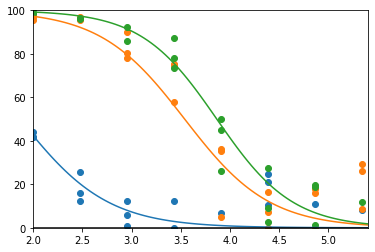

In [5]:
###make plot
xvalues = []
for i in range(len(logdil)):
    extra = [logdil[i]] * replicates
    xvalues.extend(extra)
for i in range(len(sample_y)):
    plt.scatter(xvalues, sample_y[i])
    plt.xlim(2, 5.4)
    plt.ylim(0, 100)
print("IC50 values: ", l_IC50)
print("Hill Slopes: ", l_Hill)
line_x = np.linspace(2,5.6,100)
for nr in range(3):
    ys = neutr_curve(line_x, l_IC50[nr], l_Hill[nr])
    plt.plot(line_x, ys)
plt.axhline(0, color='black')

In [6]:
###write y_measured to csv
##Make dataframe from lists
#reorder dataframe
rlu1 = pd.DataFrame([])
rlu2 = pd.DataFrame([])
rlu3 = pd.DataFrame([])
ordered = [rlu1, rlu2, rlu3]

for nr in range(3):
    ordered[nr] = [[],[],[]]
    for r in sample_y[nr]:
        one = r[0]
        two = r[1]
        three = r[2]
        ordered[nr][0].append(one)
        ordered[nr][1].append(two)
        ordered[nr][2].append(three)

for t in range(3):
    for h in ordered[t]:
        h.append( 100)
        h.append( 0)

csvlog = np.append(logdil,["min","max"])

dicto = {"log(dil)": csvlog, "Sample 1a": ordered[0][0], "Sample 1b": ordered[0][1], "Sample 1c": ordered[0][2], "Sample 2a": ordered[1][0],"Sample 2b": ordered[1][1], "Sample 2c": ordered[1][2],"Sample 3a": ordered[2][0],"Sample 3b": ordered[2][1],"Sample 3c": ordered[2][2]}
df = pd.DataFrame(dicto)


In [7]:
df.to_csv("Newvalues.csv", ";", decimal = ",", index= False)